In [1]:
import pandas

import numpy

from matplotlib import pyplot
import matplotlib
import numpy

from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.cluster import KMeans, MeanShift, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, homogeneity_completeness_v_measure, v_measure_score, precision_score
from sklearn.model_selection import GridSearchCV
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings('ignore')

Чтение и обработка данных

In [2]:
def encode_onehot_categorical(frame, columns):
    """
    Кодирует столбцы columns с помощью OneHotEncoder, удаляя первоначальные столбцы
    :param frame: таблица DataFrame
    :param columns: кодируемые столбцы
    :return: новая таблица
    """
    encoder = OneHotEncoder()
    for column in columns:
        transformed = encoder.fit_transform(frame[[column]]).toarray()
        cols = list(encoder.get_feature_names_out())[:-1]
        new_frame = pandas.DataFrame(transformed, columns=encoder.get_feature_names_out())
        new_frame = new_frame[cols]
        frame = frame.join(new_frame)

    frame = frame.drop(columns=columns)
    return frame

def cluster_evaluation(x, model, y=None):
    pred = pandas.Series(model.predict(x))
    metrics = {
         'Silhouette coefficient': silhouette_score(x, pred),}
    if y is not None:
        count = (pred == y).sum()
        metrics["Adjusted Rand index"] = adjusted_rand_score(y, pred)
        metrics['Adjusted Mutual Information'] = adjusted_mutual_info_score(y, pred),
        metrics["Homogenity, completness, V measure"] = homogeneity_completeness_v_measure(y, pred)
        metrics['Совпавшие элементы'] = count
        metrics['Несовпавшие элементы'] = len(y) - count
    return metrics

In [3]:
categorical = ['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch']
numeric = ['Fare', 'Age']
frame = pandas.read_csv("train.csv")
frame.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,486,0,3,"Lefebre, Miss. Jeannie",female,NaN,3,1,4133,25.4667,NaN,S
1,426,0,3,"Wiseman, Mr. Phillippe",male,NaN,0,0,A/4. 34244,7.2500,NaN,S
2,780,1,1,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",female,43.0,0,1,24160,211.3375,B3,S
3,248,1,2,"Hamalainen, Mrs. William (Anna)",female,24.0,0,2,250649,14.5000,NaN,S
4,184,1,2,"Becker, Master. Richard F",male,1.0,2,1,230136,39.0000,F4,S


In [4]:
print(frame.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            102
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          414
Embarked         0
dtype: int64


In [5]:
# Удаление метки классов
frame["Age"] = frame["Age"].fillna(frame["Age"].mean())
frame = frame.drop(columns=["Cabin", "PassengerId", "Ticket", "Name"])
frame = encode_onehot_categorical(frame, categorical)
x = frame.drop(columns="Survived")
y = frame['Survived']
frame[numeric] = MinMaxScaler().fit_transform(frame[numeric])

In [6]:
frame

,Survived,Age,Fare,Pclass_1,Pclass_2,Sex_female,Embarked_C,Embarked_Q,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5
0,0,0.366834,0.049708,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,0.366834,0.014151,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,0.535059,0.412503,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,0.296306,0.028302,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,0.007288,0.076123,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,0,0.019854,0.054457,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
530,0,0.032420,0.041136,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
531,0,0.366834,0.049708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
532,1,0.296306,0.036598,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Кластеризация

In [7]:
km_model = KMeans(n_clusters=2)
km_model.fit(x)
pred = km_model.labels_

In [8]:
cluster_evaluation(x, km_model, y=y)

{'Silhouette coefficient': 0.8176597279501655,
 'Adjusted Rand index': 0.036497870497107045,
 'Adjusted Mutual Information': (0.04025874098775917,),
 'Homogenity, completness, V measure': (0.026845878510062936,
  0.10118933446149292,
  0.04243389793198316),
 'Совпавшие элементы': 194,
 'Несовпавшие элементы': 340}

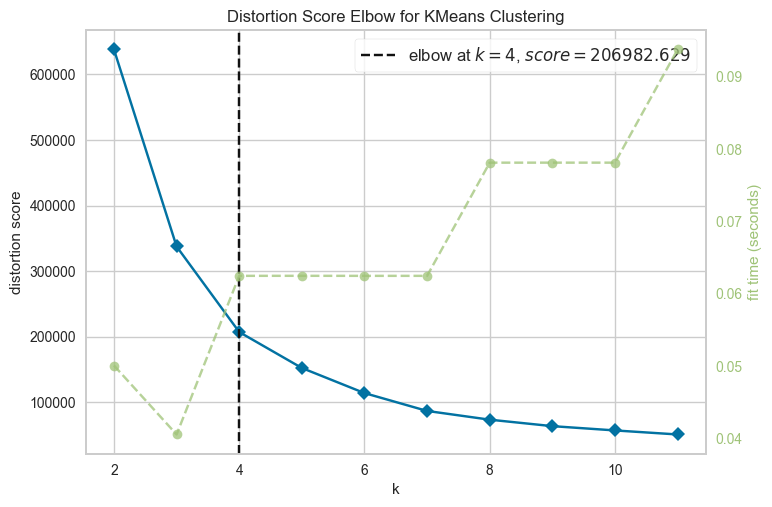

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
visualizer = KElbowVisualizer(km_model, k=(2,12))

visualizer.fit(x)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [10]:
elbow_best_model = KMeans(n_clusters=4).fit(x, y)
elbow_pred = elbow_best_model.predict(x)
cluster_evaluation(x, elbow_best_model)

{'Silhouette coefficient': 0.6567818232617281}

Отрисовка PCA

In [11]:
def build_PCA(x, model):
    pca = PCA(n_components=2)
    data = pca.fit_transform(x)
    model.fit(data)
    pred = model.labels_
    ax = pyplot.axes()
    pyplot.xlabel('PCA1')
    pyplot.ylabel('PCA2')
    pyplot.scatter(data[:, 0], data[:, 1], c=pred, edgecolors='blue')
    pyplot.show()

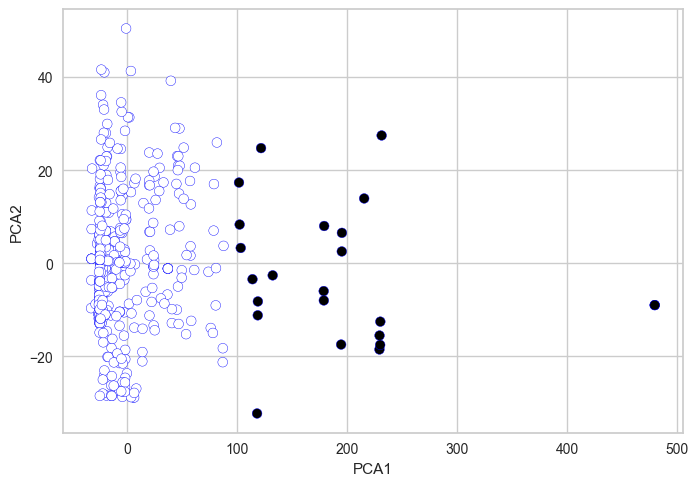

In [12]:
build_PCA(x, KMeans(n_clusters=2))

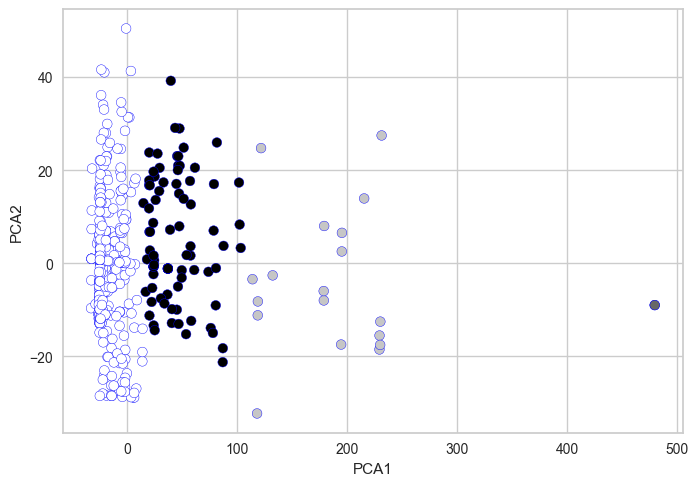

In [13]:
build_PCA(x, KMeans(n_clusters=4))

AffinityPropagation

In [14]:
scores = {}
for damping in [x/100 for x in range(50, 100, 5)]:
    cluster = AffinityPropagation(damping=damping).fit(x)
    pred = cluster.labels_
    scores[damping] = silhouette_score(x, pred)
best_damping = max(scores.keys(), key=lambda x: scores[x])
print(f"Лучшее значение damping = {best_damping}. Score = {scores[best_damping]}")


Лучшее значение damping = 0.75. Score = 0.4605672874057423


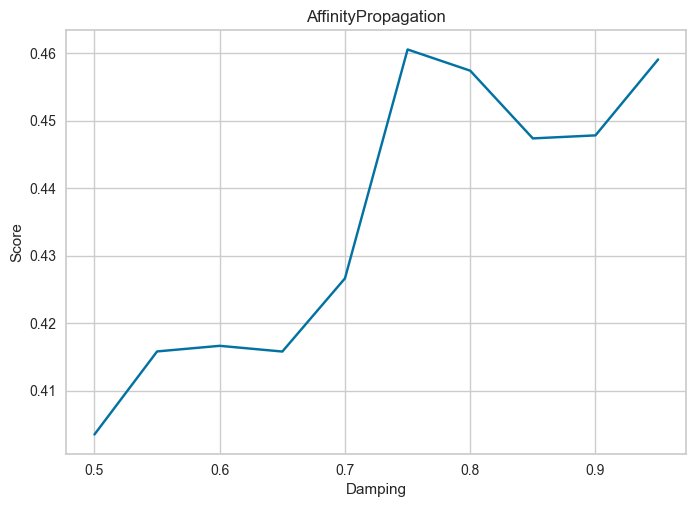

In [15]:
pyplot.title("AffinityPropagation")
pyplot.xlabel("Damping")
pyplot.ylabel("Score")
pyplot.plot(scores.keys(), scores.values())

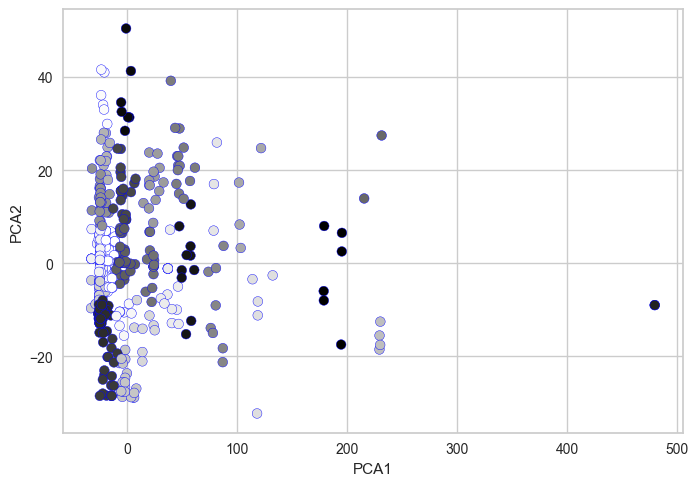

Количество кластеров = 28


In [17]:
model = AffinityPropagation(damping=0.75)
build_PCA(x, model)
print(f"Количество кластеров = {len(numpy.unique(model.labels_))}")

<BarContainer object of 2 artists>

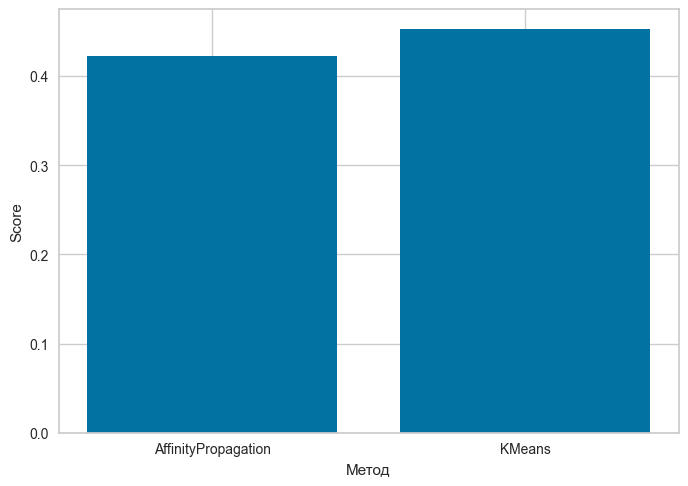

In [21]:
k_means = KMeans(n_clusters=28).fit(x)

scores = (silhouette_score(x, model.labels_), silhouette_score(x, k_means.labels_))
names = ("AffinityPropagation", "KMeans")
pyplot.xlabel("Метод")
pyplot.ylabel("Score")
pyplot.bar(names, scores)